# CEO-Request Challenge

Should Olist remove under-performing sellers from its marketplace? 🕵🏻


To analyze the impact of removing the worse sellers from Olist's marketplace, we will perform a what-if analysis

👉 What would have happened if Olist had never accepted these sellers in the first place?

(In practice, it's hard to know in advance who is a good seller, but let's start with this approach and iterate later).

In [220]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Preparation

In [164]:
from olist.seller import Seller
sellers = Seller().get_training_data()
sellers.head(2)

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,total_sub,n_orders,quantity,quantity_per_order,sales,sales_fees,share_of_five_stars,share_of_one_stars,review_score
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.0,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,320.0,3,3,1.000,218.70,21.870,0.333333,0.333333,3.000000
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.0,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,1120.0,40,41,1.025,11703.07,1170.307,0.731707,0.048780,4.560976


In [165]:
from olist.seller import Order
order_reviews = Order().get_review_score()
order_reviews.head(2)

,order_id,dim_is_five_star,dim_is_one_star,review_score
0,73fc7af87114b39712e6da79b0a377eb,0,0,4
1,a548910a1c6147796b98fdf73dbeba33,1,0,5


In [166]:
sellers.columns

Index(['seller_id', 'seller_city', 'seller_state', 'delay_to_carrier',
       'wait_time', 'date_first_sale', 'date_last_sale', 'months_on_olist',
       'total_sub', 'n_orders', 'quantity', 'quantity_per_order', 'sales',
       'sales_fees', 'share_of_five_stars', 'share_of_one_stars',
       'review_score'],
      dtype='object')

In [167]:
order_reviews.columns

Index(['order_id', 'dim_is_five_star', 'dim_is_one_star', 'review_score'], dtype='object')

### Revenue

In [168]:
# Computing the total revenue within the class

revenue_sel = Seller().get_revenue()
revenue_sel

,seller_id,sales_fees,total_sub,total_revenue
0,0015a82c2db000af6aaaf3ae2ecb0532,268.500,80.0,348.500
1,001cca7ae9ae17fb1caed9dfb1094831,2508.003,1360.0,3868.003
2,001e6ad469a905060d959994f1b41e4f,25.000,0.0,25.000
3,002100f778ceb8431b7a1020ff7ab48f,123.450,560.0,683.450
4,003554e2dce176b5555353e4f3555ac8,12.000,0.0,12.000
...,...,...,...,...
3090,ffcfefa19b08742c5d315f2791395ee5,6.990,0.0,6.990
3091,ffdd9f82b9a447f6f8d4b91554cc7dd3,210.120,1440.0,1650.120
3092,ffeee66ac5d5a62fe688b9d26f83f534,183.986,560.0,743.986
3093,fffd5413c0700ac820c7069d66d98c89,906.230,1040.0,1946.230


In [169]:
# Computing the total revenue in this notebook

sellers['revenue'] = sellers['sales_fees'] + sellers['total_sub']
sellers.head(3)

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,total_sub,n_orders,quantity,quantity_per_order,sales,sales_fees,share_of_five_stars,share_of_one_stars,review_score,revenue
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.0,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,320.0,3,3,1.000,218.70,21.870,0.333333,0.333333,3.000000,341.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.0,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,1120.0,40,41,1.025,11703.07,1170.307,0.731707,0.048780,4.560976,2290.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.0,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.0,1,1,1.000,158.00,15.800,1.000000,0.000000,5.000000,15.800


In [170]:
revenue = sellers[['seller_id', 'revenue']].drop_duplicates()

In [171]:
revenue

,seller_id,revenue
0,3442f8959a84dea7ee197c632cb2df15,341.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,2290.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,15.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,7.999
4,51a04a8a6bdcb23deccc82b0b80742cf,16.799
...,...,...
2962,98dddbc4601dd4443ca174359b237166,15.800
2963,f8201cab383e484733266d1906e2fdfa,1208.900
2964,74871d19219c7d518d0090283e03c137,455.004
2965,e603cf3fec55f8697c9059638d6c8eb5,349.700


### Cost of Reviews

In [172]:
from olist.data import Olist
data_df = Olist().get_data()

In [173]:
ids = data_df['order_items'][['order_id', 'seller_id']].drop_duplicates()
ids

,order_id,seller_id
0,00010242fe8c5a6d1ba2dd792cb16214,48436dade18ac8b2bce089ec2a041202
1,00018f77f2f0320c557190d7a144bdd3,dd7ddc04e1b6c2c614352b383efe2d36
2,000229ec398224ef6ca0657da4fc703e,5b51032eddd242adc84c38acab88f23d
3,00024acbcdf0a6daa1e931b038114c75,9d7a1d34a5052409006425275ba1c2b4
4,00042b26cf59d7ce69dfabb4e55b4fd9,df560393f3a51e74553ab94004ba5c87
...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,b8bc237ba3788b23da09c0f1f3a3288c
112646,fffcd46ef2263f404302a634eb57f7eb,f3c38ab652836d21de61fb8314b69182
112647,fffce4705a9662cd70adb13d4a31832d,c3cfdc648177fdbbbb35635a37472c53
112648,fffe18544ffabc95dfada21779c9644f,2b3e4a2a3ea8e01938cabda2a3e5cc79


In [174]:
df = pd.merge(ids, order_reviews, on='order_id', how='inner')
df.head()

,order_id,seller_id,dim_is_five_star,dim_is_one_star,review_score
0,00010242fe8c5a6d1ba2dd792cb16214,48436dade18ac8b2bce089ec2a041202,1,0,5
1,00018f77f2f0320c557190d7a144bdd3,dd7ddc04e1b6c2c614352b383efe2d36,0,0,4
2,000229ec398224ef6ca0657da4fc703e,5b51032eddd242adc84c38acab88f23d,1,0,5
3,00024acbcdf0a6daa1e931b038114c75,9d7a1d34a5052409006425275ba1c2b4,0,0,4
4,00042b26cf59d7ce69dfabb4e55b4fd9,df560393f3a51e74553ab94004ba5c87,1,0,5


In [175]:
df['cost_of_review'] = order_reviews.review_score.map({1: 100, 2: 50, 3: 40, 4: 0, 5: 0})
df.head(10)

,order_id,seller_id,dim_is_five_star,dim_is_one_star,review_score,cost_of_review
0,00010242fe8c5a6d1ba2dd792cb16214,48436dade18ac8b2bce089ec2a041202,1,0,5,0.0
1,00018f77f2f0320c557190d7a144bdd3,dd7ddc04e1b6c2c614352b383efe2d36,0,0,4,0.0
2,000229ec398224ef6ca0657da4fc703e,5b51032eddd242adc84c38acab88f23d,1,0,5,0.0
3,00024acbcdf0a6daa1e931b038114c75,9d7a1d34a5052409006425275ba1c2b4,0,0,4,0.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,df560393f3a51e74553ab94004ba5c87,1,0,5,0.0
5,00048cc3ae777c65dbb7d2a0634bc1ea,6426d21aca402a131fc0a5d0960a3c90,0,0,4,100.0
6,00054e8431b9d7675808bcb819fb4a32,7040e82f899a04d1b434b795a43b4617,0,0,4,0.0
7,000576fe39319847cbb9d288c5617fa6,5996cddab893a4652a15592fb58ab8db,1,0,5,0.0
8,0005a1a1728c9d785b8e2b08b904576c,a416b6a846a11724393025641d4edd5e,0,1,1,0.0
9,0005f50442cb953dcd1d21e1fb923495,ba143b05f0110f0dc71ad71b4466ce92,0,0,4,0.0


In [176]:
df = df.groupby(['seller_id']).agg({'dim_is_one_star': 'mean', 
                                    'dim_is_five_star': 'mean',
                                    'review_score': 'mean', 
                                    'cost_of_review': 'sum'}).reset_index()
df.head(3)

,seller_id,dim_is_one_star,dim_is_five_star,review_score,cost_of_review
0,0015a82c2db000af6aaaf3ae2ecb0532,0.333333,0.666667,3.666667,140.0
1,001cca7ae9ae17fb1caed9dfb1094831,0.121827,0.527919,3.984772,3560.0
2,001e6ad469a905060d959994f1b41e4f,1.000000,0.000000,1.000000,0.0


In [177]:
df.columns = ['seller_id', 'share_of_one_stars', 'share_of_five_stars', 'review_score', 'cost_of_reviews']
df.head(3)

,seller_id,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews
0,0015a82c2db000af6aaaf3ae2ecb0532,0.333333,0.666667,3.666667,140.0
1,001cca7ae9ae17fb1caed9dfb1094831,0.121827,0.527919,3.984772,3560.0
2,001e6ad469a905060d959994f1b41e4f,1.000000,0.000000,1.000000,0.0


In [178]:
final_df = pd.merge(df, revenue, on='seller_id', how='inner')
final_df.head()

,seller_id,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,revenue
0,0015a82c2db000af6aaaf3ae2ecb0532,0.333333,0.666667,3.666667,140.0,348.500
1,001cca7ae9ae17fb1caed9dfb1094831,0.121827,0.527919,3.984772,3560.0,3868.003
2,002100f778ceb8431b7a1020ff7ab48f,0.134615,0.519231,3.903846,840.0,683.450
3,003554e2dce176b5555353e4f3555ac8,0.000000,1.000000,5.000000,0.0,12.000
4,004c9cd9d87a3c30c522c48c4fc07416,0.080745,0.596273,4.136646,2400.0,3171.271


### Profits

In [179]:
final_df['profits'] = final_df['revenue'] - final_df['cost_of_reviews']
final_df.head(3)

,seller_id,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,revenue,profits
0,0015a82c2db000af6aaaf3ae2ecb0532,0.333333,0.666667,3.666667,140.0,348.500,208.500
1,001cca7ae9ae17fb1caed9dfb1094831,0.121827,0.527919,3.984772,3560.0,3868.003,308.003
2,002100f778ceb8431b7a1020ff7ab48f,0.134615,0.519231,3.903846,840.0,683.450,-156.550


In [188]:
# profits ONLY to be merged with initial 'sellers' df that already contains:

# - share_of_five_stars
# - share_of_one_stars
# - review_score
# - revenue

profits_df = final_df[['seller_id','profits']]
profits_df

,seller_id,profits
0,0015a82c2db000af6aaaf3ae2ecb0532,208.500
1,001cca7ae9ae17fb1caed9dfb1094831,308.003
2,002100f778ceb8431b7a1020ff7ab48f,-156.550
3,003554e2dce176b5555353e4f3555ac8,12.000
4,004c9cd9d87a3c30c522c48c4fc07416,771.271
...,...,...
2962,ffc470761de7d0232558ba5e786e57b7,164.901
2963,ffdd9f82b9a447f6f8d4b91554cc7dd3,1270.120
2964,ffeee66ac5d5a62fe688b9d26f83f534,563.986
2965,fffd5413c0700ac820c7069d66d98c89,1156.230


In [189]:
# df to be used for the model ?

sel_profit = pd.merge(sellers, profits_df, on='seller_id', how='inner')
sel_profit.head(3)

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,total_sub,n_orders,quantity,quantity_per_order,sales,sales_fees,share_of_five_stars,share_of_one_stars,review_score,revenue,profits
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.0,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,320.0,3,3,1.000,218.70,21.870,0.333333,0.333333,3.000000,341.870,341.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.0,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,1120.0,40,41,1.025,11703.07,1170.307,0.731707,0.048780,4.560976,2290.307,1690.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.0,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.0,1,1,1.000,158.00,15.800,1.000000,0.000000,5.000000,15.800,15.800


In [180]:
# Preparing to commit the first step on git

! pwd

/Users/carinaremes/code/carinarms/data-recap_ceo_request


In [181]:
! git add OLIST-Challenge.ipynb

In [182]:
! git commit -m 'First Data Preparation step'

[master 47fcad1] First Data Preparation step
 1 file changed, 281 insertions(+), 37 deletions(-)


In [183]:
! git push origin master

Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 4 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 3.41 KiB | 3.41 MiB/s, done.
Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To github.com:carinarms/data-recap_ceo_request.git
   d33db52..47fcad1  master -> master


## What-if Analysis

### Method for IT Costs

1️⃣ Create a method that will help us update the IT Costs after removing sellers along with the products they sold


In [235]:
# computed in order.py, Order Class:

it_costs_f = Order().get_IT_costs()
it_costs_f

1299007.8815875214

### Sorting sellers

2️⃣ Sort sellers by increasing profits

In [206]:
sel_profit.head(3)

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,total_sub,n_orders,quantity,quantity_per_order,sales,sales_fees,share_of_five_stars,share_of_one_stars,review_score,revenue,profits
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.0,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,320.0,3,3,1.000,218.70,21.870,0.333333,0.333333,3.000000,341.870,341.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.0,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,1120.0,40,41,1.025,11703.07,1170.307,0.731707,0.048780,4.560976,2290.307,1690.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.0,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.0,1,1,1.000,158.00,15.800,1.000000,0.000000,5.000000,15.800,15.800


In [231]:
sel_profit['seller_id'].count()

2967

In [205]:
sorted_sellers = sel_profit.sort_values(['profits']).reset_index()
sorted_sellers.head(3)

,index,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,total_sub,n_orders,quantity,quantity_per_order,sales,sales_fees,share_of_five_stars,share_of_one_stars,review_score,revenue,profits
0,769,6560211a19b47992c3666cc44a7e94c0,sao paulo,SP,0.0,9.539486,2017-02-17 07:45:11,2018-08-29 09:25:12,18.0,1440.0,1854,2033,1.096548,123304.83,12330.483,0.506931,0.132178,3.909406,13770.483,-18149.517
1,1357,cc419e0650a3c5ba77189a1882b7556a,santo andre,SP,0.0,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,19.0,1520.0,1706,1775,1.040445,104288.42,10428.842,0.581447,0.118719,4.069575,11948.842,-16861.158
2,315,8b321bb669392f5163d04c59e235e066,sao paulo,SP,0.0,12.616899,2017-10-27 16:31:30,2018-08-21 17:08:38,10.0,800.0,943,1018,1.079533,17535.69,1753.569,0.546351,0.130178,3.995069,2553.569,-13656.431


In [224]:
sorted_sellers.describe()

,index,delay_to_carrier,wait_time,months_on_olist,total_sub,n_orders,quantity,quantity_per_order,sales,sales_fees,share_of_five_stars,share_of_one_stars,review_score,revenue,profits
count,2967.00000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000
mean,1483.00000,0.385636,12.139417,6.025615,482.049208,33.650489,37.897203,1.157337,4568.852187,456.885219,0.589328,0.126832,4.074920,938.934427,391.570086
std,856.64345,2.295812,7.069233,5.994211,479.536871,107.182856,121.514362,0.439557,14191.836779,1419.183678,0.283198,0.195180,0.824301,1660.761719,1118.205598
min,0.00000,0.000000,1.214178,0.000000,0.000000,1.000000,1.000000,1.000000,6.500000,0.650000,0.000000,0.000000,1.000000,0.650000,-18149.517000
25%,741.50000,0.000000,8.287658,1.000000,80.000000,2.000000,3.000000,1.000000,239.850000,23.985000,0.455121,0.000000,3.785714,120.593500,19.745000
50%,1483.00000,0.000000,11.115143,4.000000,320.000000,7.000000,8.000000,1.000000,896.000000,89.600000,0.600000,0.061947,4.200000,460.480000,241.483000
75%,2224.50000,0.000000,14.231984,10.000000,800.000000,23.000000,26.000000,1.142857,3583.995000,358.399500,0.760952,0.166667,4.636364,1184.409000,660.491000
max,2966.00000,45.434039,189.863160,23.000000,1840.000000,1854.000000,2033.000000,15.000000,229472.630000,22947.263000,1.000000,1.000000,5.000000,24387.263000,18897.605000


In [240]:
# Focusing on negative sellers

neg_seller = sorted_sellers[sorted_sellers['profits'] < 0]
neg_seller

,index,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,total_sub,n_orders,quantity,quantity_per_order,sales,sales_fees,share_of_five_stars,share_of_one_stars,review_score,revenue,profits
0,769,6560211a19b47992c3666cc44a7e94c0,sao paulo,SP,0.0,9.539486,2017-02-17 07:45:11,2018-08-29 09:25:12,18.0,1440.0,1854,2033,1.096548,123304.83,12330.483,0.506931,0.132178,3.909406,13770.483,-18149.517
1,1357,cc419e0650a3c5ba77189a1882b7556a,santo andre,SP,0.0,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,19.0,1520.0,1706,1775,1.040445,104288.42,10428.842,0.581447,0.118719,4.069575,11948.842,-16861.158
2,315,8b321bb669392f5163d04c59e235e066,sao paulo,SP,0.0,12.616899,2017-10-27 16:31:30,2018-08-21 17:08:38,10.0,800.0,943,1018,1.079533,17535.69,1753.569,0.546351,0.130178,3.995069,2553.569,-13656.431
3,945,ea8482cd71df3c1969d7b9473ff13abc,sao paulo,SP,0.0,13.315562,2017-08-16 15:15:26,2018-08-25 02:45:21,12.0,960.0,1146,1203,1.049738,37177.52,3717.752,0.517962,0.124478,3.953216,4677.752,-12372.248
4,453,1f50f920176fa81dab994f9023523100,sao jose do rio preto,SP,0.0,15.571831,2017-04-03 22:15:14,2018-08-28 03:45:18,17.0,1360.0,1404,1931,1.375356,106939.21,10693.921,0.567288,0.145963,3.982402,12053.921,-12346.079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,2597,5ef131ac72773e5b3f6c0d63cf424657,ribeirao preto,SP,0.0,6.272232,2018-07-05 16:40:50,2018-08-25 17:04:13,2.0,160.0,10,11,1.100000,575.79,57.579,0.636364,0.272727,3.818182,217.579,-2.421
402,2939,d66c11a9572221d92fbb8c4897db5f9b,rio de janeiro,RJ,0.0,8.548738,2018-06-23 22:35:00,2018-08-22 18:50:22,2.0,160.0,16,16,1.000000,776.56,77.656,0.687500,0.000000,4.562500,237.656,-2.344
403,1722,213b25e6f54661939f11710a6fddb871,salto,SP,0.0,15.226613,2017-11-21 21:36:57,2018-08-14 08:10:23,9.0,720.0,155,194,1.251613,15379.50,1537.950,0.463542,0.151042,3.791667,2257.950,-2.050
404,730,76ea5315acb3f5f7ade3cd261faf922a,sao paulo,SP,0.0,8.683985,2018-05-18 10:46:17,2018-08-20 12:15:33,3.0,240.0,15,15,1.000000,1087.06,108.706,0.666667,0.066667,4.266667,348.706,-1.294


==> 406 sellers causing negative revenue - losses

In [241]:
neg_seller.corr().style.background_gradient(cmap='coolwarm')

,index,delay_to_carrier,wait_time,months_on_olist,total_sub,n_orders,quantity,quantity_per_order,sales,sales_fees,share_of_five_stars,share_of_one_stars,review_score,revenue,profits
index,1.000000,0.017940,0.061302,-0.000263,-0.000263,0.003834,0.006744,-0.023560,0.051250,0.051250,-0.041446,-0.034149,0.005946,0.044550,0.036305
delay_to_carrier,0.017940,1.000000,0.202259,-0.108536,-0.108536,-0.075863,-0.075328,-0.025325,-0.058904,-0.058904,-0.077597,0.034583,-0.088897,-0.073712,0.058267
wait_time,0.061302,0.202259,1.000000,0.008008,0.008008,0.022058,0.022937,-0.030539,0.025017,0.025017,-0.207677,0.390876,-0.354618,0.023429,-0.020448
months_on_olist,-0.000263,-0.108536,0.008008,1.000000,1.000000,0.651728,0.644593,0.034872,0.554896,0.554896,-0.059192,0.083929,-0.078562,0.689753,-0.466511
total_sub,-0.000263,-0.108536,0.008008,1.000000,1.000000,0.651728,0.644593,0.034872,0.554896,0.554896,-0.059192,0.083929,-0.078562,0.689753,-0.466511
n_orders,0.003834,-0.075863,0.022058,0.651728,0.651728,1.000000,0.993351,0.024732,0.920027,0.920027,-0.046088,0.051470,-0.056489,0.935511,-0.867412
quantity,0.006744,-0.075328,0.022937,0.644593,0.644593,0.993351,1.000000,0.047796,0.928552,0.928552,-0.047496,0.056442,-0.060298,0.941455,-0.847338
quantity_per_order,-0.023560,-0.025325,-0.030539,0.034872,0.034872,0.024732,0.047796,1.000000,0.041785,0.041785,-0.079187,0.157162,-0.161655,0.043578,0.000492
sales,0.051250,-0.058904,0.025017,0.554896,0.554896,0.920027,0.928552,0.041785,1.000000,1.000000,-0.042819,0.051734,-0.054515,0.985088,-0.632762
sales_fees,0.051250,-0.058904,0.025017,0.554896,0.554896,0.920027,0.928552,0.041785,1.000000,1.000000,-0.042819,0.051734,-0.054515,0.985088,-0.632762


Text(0.5, 0, 'seller id')

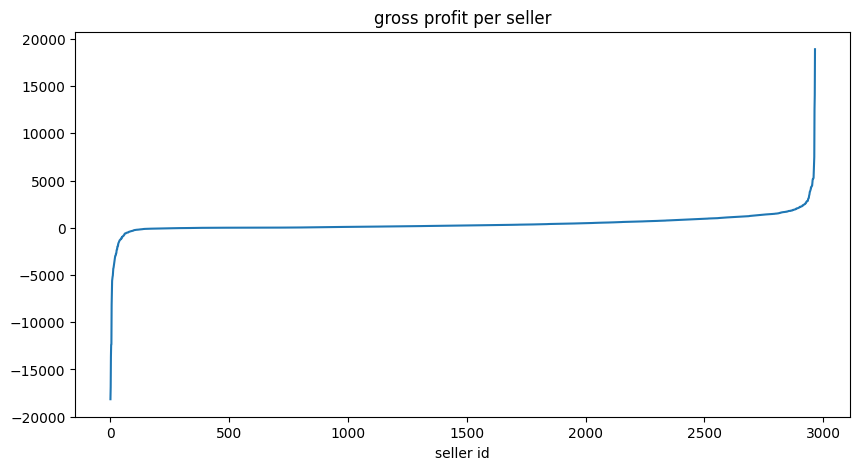

In [208]:
plt.figure(figsize=(10, 5))
sorted_sellers.profits.plot()
plt.title('gross profit per seller')
plt.xlabel('seller id')

Text(0.5, 0, 'seller id')

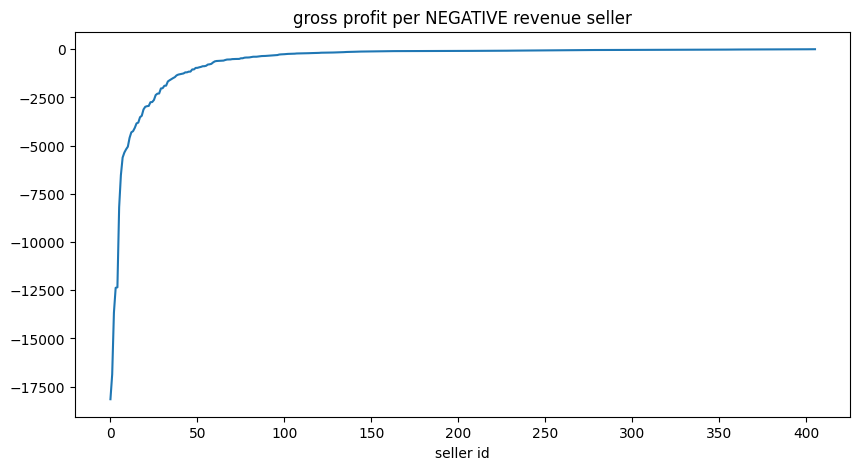

In [243]:
plt.figure(figsize=(10, 5))
neg_seller.profits.plot()
plt.title('gross profit per NEGATIVE revenue seller')
plt.xlabel('seller id')

In [244]:
# Looking into something else:...

In [214]:
sorted_sellers.corr().style.background_gradient(cmap='coolwarm')

,index,delay_to_carrier,wait_time,months_on_olist,total_sub,n_orders,quantity,quantity_per_order,sales,sales_fees,share_of_five_stars,share_of_one_stars,review_score,revenue,profits
index,1.000000,0.035352,0.010755,0.010086,0.010086,-0.008854,-0.008752,0.033242,-0.004791,-0.004791,-0.012645,0.013767,-0.006882,-0.001182,0.008703
delay_to_carrier,0.035352,1.000000,0.465205,-0.084241,-0.084241,-0.045109,-0.044400,0.031106,-0.036824,-0.036824,-0.188033,0.329628,-0.298825,-0.055792,-0.011727
wait_time,0.010755,0.465205,1.000000,0.069197,0.069197,0.014792,0.015670,0.006041,0.039995,0.039995,-0.299297,0.394407,-0.403822,0.054158,0.055632
months_on_olist,0.010086,-0.084241,0.069197,1.000000,1.000000,0.403276,0.399137,-0.007920,0.377703,0.377703,-0.049454,0.001625,-0.030883,0.611506,0.278722
total_sub,0.010086,-0.084241,0.069197,1.000000,1.000000,0.403276,0.399137,-0.007920,0.377703,0.377703,-0.049454,0.001625,-0.030883,0.611506,0.278722
n_orders,-0.008854,-0.045109,0.014792,0.403276,0.403276,1.000000,0.993438,-0.022247,0.798981,0.798981,-0.022242,-0.007044,-0.009388,0.799203,-0.383344
quantity,-0.008752,-0.044400,0.015670,0.399137,0.399137,0.993438,1.000000,-0.003549,0.795229,0.795229,-0.025502,-0.002111,-0.014393,0.794802,-0.381398
quantity_per_order,0.033242,0.031106,0.006041,-0.007920,-0.007920,-0.022247,-0.003549,1.000000,-0.023534,-0.023534,-0.038106,0.106693,-0.090559,-0.022398,-0.000049
sales,-0.004791,-0.036824,0.039995,0.377703,0.377703,0.798981,0.795229,-0.023534,1.000000,1.000000,-0.020749,0.000960,-0.012385,0.963598,0.185732
sales_fees,-0.004791,-0.036824,0.039995,0.377703,0.377703,0.798981,0.795229,-0.023534,1.000000,1.000000,-0.020749,0.000960,-0.012385,0.963598,0.185732


Strong correlation between revenue and:
- months_on_olist
- total_sub
- n_orders
- quantity
- sales
- sales fees

In [251]:
# sorted_sellers['rev1-0'] = sorted_sellers['profits'].apply(lambda cell: 1 if sorted_sellers['profits'] > 0 else 0)
sorted_sellers['rev1-0'] = sorted_sellers['rev1-0'].loc[sorted_sellers['profits'] < 0, 'rev1-0'] = 0
sorted_sellers['rev1-0'] = sorted_sellers[.loc[sorted_sellers['profits'] > 0, 'rev1-0'] = 1


# sorted_sellers.loc[sorted_sellers['profits'] < 4, 'column_name'] = 0
# sorted_sellers.loc[sorted_sellers['profits'] > 4, 'column_name'] = 1

In [253]:
sorted_sellers.head(20)

,index,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,total_sub,...,quantity,quantity_per_order,sales,sales_fees,share_of_five_stars,share_of_one_stars,review_score,revenue,profits,rev1-0
0,769,6560211a19b47992c3666cc44a7e94c0,sao paulo,SP,0.0,9.539486,2017-02-17 07:45:11,2018-08-29 09:25:12,18.0,1440.0,...,2033,1.096548,123304.83,12330.483,0.506931,0.132178,3.909406,13770.483,-18149.517,1
1,1357,cc419e0650a3c5ba77189a1882b7556a,santo andre,SP,0.0,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,19.0,1520.0,...,1775,1.040445,104288.42,10428.842,0.581447,0.118719,4.069575,11948.842,-16861.158,1
2,315,8b321bb669392f5163d04c59e235e066,sao paulo,SP,0.0,12.616899,2017-10-27 16:31:30,2018-08-21 17:08:38,10.0,800.0,...,1018,1.079533,17535.69,1753.569,0.546351,0.130178,3.995069,2553.569,-13656.431,1
3,945,ea8482cd71df3c1969d7b9473ff13abc,sao paulo,SP,0.0,13.315562,2017-08-16 15:15:26,2018-08-25 02:45:21,12.0,960.0,...,1203,1.049738,37177.52,3717.752,0.517962,0.124478,3.953216,4677.752,-12372.248,1
4,453,1f50f920176fa81dab994f9023523100,sao jose do rio preto,SP,0.0,15.571831,2017-04-03 22:15:14,2018-08-28 03:45:18,17.0,1360.0,...,1931,1.375356,106939.21,10693.921,0.567288,0.145963,3.982402,12053.921,-12346.079,1
5,2358,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,0.0,14.416471,2017-01-08 09:45:12,2018-08-27 11:04:18,20.0,1600.0,...,1987,1.100221,200472.92,20047.292,0.477319,0.148185,3.803931,21647.292,-8192.708,1
6,1196,128639473a139ac0f3e5f5ade55873a5,maringa,PR,0.0,14.412933,2017-05-12 23:25:11,2018-08-21 04:35:32,15.0,1200.0,...,560,1.050657,11908.85,1190.885,0.574007,0.079422,4.176895,2390.885,-6529.115,1
7,2729,f8db351d8c4c4c22c6835c19a46f01b0,salto,SP,0.0,9.914259,2017-01-25 23:02:13,2018-08-25 20:10:12,19.0,1520.0,...,724,1.085457,50525.60,5052.560,0.592798,0.078947,4.218837,6572.560,-5617.440,1
8,1213,d2374cbcbb3ca4ab1086534108cc3ab7,ibitinga,SP,0.0,14.297115,2017-02-10 15:50:20,2018-08-22 04:04:20,18.0,1440.0,...,631,1.204198,21223.92,2122.392,0.446841,0.186441,3.636364,3562.392,-5357.608,1
9,1920,85d9eb9ddc5d00ca9336a2219c97bb13,belo horizonte,MG,0.0,14.738471,2016-10-06 15:53:38,2018-08-21 04:29:37,22.0,1760.0,...,522,1.025540,15415.24,1541.524,0.555556,0.076628,4.172414,3301.524,-5188.476,1


In [ ]:
model1 = smf.logit(formula='rev ~ revenue', data=titanic).fit()
model1.params

3️⃣ Remove sellers one by one, starting from the one with the lowest profit.
- For each number of sellers to remove, compute the financial impact on Olist global profits.

4️⃣ Find an optimal number of sellers to remove that maximizes either Olist's profit margin or profit.

potential OTHER variables: 

- 
- seller_response_time (and but not needed: customer_response_time)
- total_product_value_by_order
- 

In [ ]:
order_reviews = Order().get_review_score()
order_reviews.head(2)